# Example: Planewave Absorption Maximization
In this example, we compute bounds on the maximum absorption of an incident planewave by a structure. 

The harmonic time-averaged absorption is

$$
f(\mathbf{e}) = \frac{\omega}{2}  \int \Im(\epsilon(\mathbf{r})) |\mathbf{e}(\mathbf{r})|^2 d \mathbf{r}
$$

Using the fact that $\Im(\epsilon(\mathbf{r})) |\mathbf{e}(\mathbf{r})|^2$ is only non-zero over the structure, we can rewrite this using the polarization field as

$$
f(\mathbf{p}) = \frac{\omega}{2} \Im\left(\chi \frac{\mathbf{p}^\dagger}{\chi^*} \frac{\mathbf{p}}{\chi} \right) = \frac{\omega}{2}\frac{\Im(\chi)}{|\chi|^2} \mathbf{p}^\dagger \mathbf{p}.
$$
Therefore, the constant and linear parts of the objective are $0$, and the quadratic part for the dense form is $A_0 = -\frac{\omega}{2}\frac{\Im(\chi)}{|\chi|^2} I = \frac{\omega}{2} \Im\left(\frac{1}{\chi} \right) I$. Note the $-$ sign when defining $A_0$: this is because the QCQP class writes the QCQP objective as
$$
\max_{\mathbf{x}} \quad -\mathbf{x}^\dagger A_0 \mathbf{x} + 2\Re(\mathbf{x^\dagger} s_0) + c_0.
$$

In [4]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import sys, time, os
from dolphindes import photonics, geometry

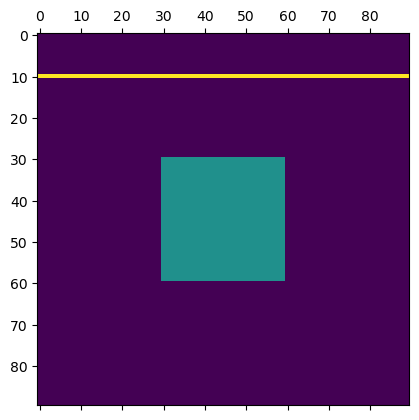

In [2]:
## wavelength, geometry and materials of the planewave absorption problem ##
wavelength = 1.0
omega = 2*np.pi / wavelength

chi = 3 + 1e-2j

px_per_length = 20 # pixels per length unit. If wavelength = 1.0, then this is pixels per wavelength.
dl = 1 / px_per_length

des_x = 1.5
des_y = 1.5 # size of the design region for the absorbing structure
pmlsep = 1.0
pmlthick = 0.5
Mx = int(des_x / dl)
My = int(des_y / dl)

Npmlsepx = Npmlsepy = int(pmlsep / dl)
Npmlx = Npmly = int(pmlthick / dl)
Nx = Mx + 2*(Npmlsepx + Npmlx)
Ny = My + 2*(Npmlsepy + Npmly)

des_mask = np.zeros((Nx,Ny), dtype=bool)
des_mask[Npmlx+Npmlsepx:-(Npmlx+Npmlsepx) , Npmly+Npmlsepy:-(Npmly+Npmlsepy)] = True
Ndes = int(np.sum(des_mask))

## planewave source
ji = np.zeros((Nx,Ny), dtype=complex)
ji[Npmlx,:] = 2.0 / dl # linesource for unit amplitude planewave traveeling in x direction

plt.matshow(des_mask + np.real(ji)*dl) # visualize where the mask and the source are

In [5]:
## setup geometry
geo = geometry.CartesianFDFDGeometry(
    Nx=Nx, Ny=Ny, Npmlx=Npmlx, Npmly=Npmly, dx=dl, dy=dl
)

## setup the photonic TM FDFD class
abs_problem = photonics.Photonics_TM_FDFD(
    omega=omega, geometry=geo, chi=chi,
    des_mask=des_mask, ji=ji, sparseQCQP=True
)

print(abs_problem)

Photonics_TM_FDFD(omega=6.283185307179586, geometry=CartesianFDFDGeometry(Nx=90, Ny=90, Npmlx=10, Npmly=10, dx=0.05, dy=0.05, bloch_x=0.0, bloch_y=0.0), chi=(3+0.01j), des_mask=True, ji=True, ei=False, chi_background=False, sparseQCQP=True)


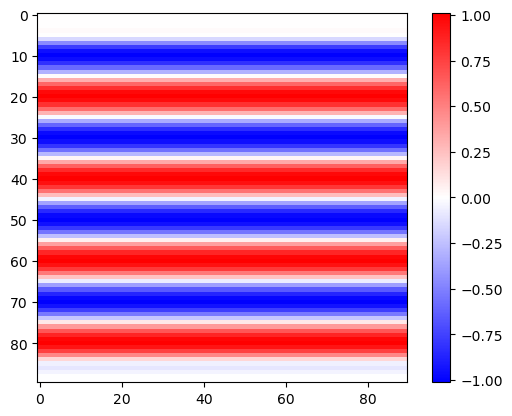

In [6]:
## obtain incident planewave and plot it
ei = abs_problem.get_ei(ji, update=True)
plt.imshow(np.real(ei), cmap='bwr')
plt.colorbar()

In [7]:
## We start by calculating limits with just the global conservation of power constraints
c0 = 0.0
s0_p = np.zeros(Ndes, dtype=complex)
A0_p = (omega/2) * np.imag(1.0/chi) * sp.eye_array(Ndes)
abs_problem.set_objective(s0=s0_p, A0=A0_p, c0=c0, denseToSparse=True) # using sparse formulation
abs_problem.setup_QCQP(Pdiags='global', verbose=1)
result = abs_problem.bound_QCQP('newton')
print(f'global constraint bound is {result[0]}')

/home/alessio/code/dolphindes/dolphindes/photonics/_base_photonics.py:278: UserWarning: If both ji and ei are specified then ji is ignored.
  warnings.warn("If both ji and ei are specified then ji is ignored.")
/home/alessio/code/dolphindes/dolphindes/cvxopt/qcqp.py:162: CholmodTypeConversionWarning: converting matrix of class csc_array to CSC format
  self.Acho = sksparse.cholmod.analyze(A)
/home/alessio/code/dolphindes/dolphindes/cvxopt/qcqp.py:207: CholmodTypeConversionWarning: converting matrix of class csc_array to CSC format
  tmp = self.Acho.cholesky(A)
/home/alessio/code/dolphindes/dolphindes/cvxopt/qcqp.py:173: CholmodTypeConversionWarning: converting matrix of class csc_array to CSC format
  self.Acho.cholesky_inplace(A)


Precomputed 2 A matrices and Fs vectors.
Found feasible point for dual problem: [6.34906485e-07 3.84433594e+00] with dualvalue 1.819551539183378
global constraint bound is 1.641256191235823


In [8]:
## if desired, we can run generalized constraint descent to tighten the bounds
abs_problem.QCQP.run_gcd()
abs_gcd_bound = abs_problem.QCQP.current_dual

Precomputed 2 A matrices and Fs vectors.
At GCD iteration #1, best dual bound found is             1.6412561899990024.
At GCD iteration #2, best dual bound found is             1.6061666209070773.
At GCD iteration #3, best dual bound found is             1.5526695867460012.
At GCD iteration #4, best dual bound found is             1.5235000738096445.
At GCD iteration #5, best dual bound found is             1.5120767768227994.
At GCD iteration #6, best dual bound found is             1.5017964757718532.
At GCD iteration #7, best dual bound found is             1.493106924032111.
At GCD iteration #8, best dual bound found is             1.4908405145595454.
At GCD iteration #9, best dual bound found is             1.4924107709732946.
At GCD iteration #10, best dual bound found is             1.4877902250712607.
At GCD iteration #11, best dual bound found is             1.486764217009258.
At GCD iteration #12, best dual bound found is             1.4834296343220257.
At GCD iteration #13, 

In [9]:
print('Bound for maximum absorption power found is', abs_gcd_bound)
Sx = 0.5 # unit amplitude planewave has Poynting vector magnitude of 0.5
print('Ratio between absorption cross section bound and geometric cross section is', abs_gcd_bound / (Sx*des_y))

Bound for maximum absorption power found is 1.4831858973124474
Ratio between absorption cross section bound and geometric cross section is 1.9775811964165966


## Compare with Inverse design

We can perform topology optimization to compare with the bounds.
For convenience, dolphindes provides built-in adjoint calculation once the design objective is specified, which can be combined with a non-linear optimization package (like [NLopt](https://nlopt.readthedocs.io/en/latest/) used here) for easy inverse design. 

In [8]:
import nlopt

In [9]:
ndof = int(np.sum(des_mask))
dof = 0.5 * np.ones(ndof) # half slab initialization

opt_data = {'count':0} # dictionary keeping track of optimization progress
def abs_objective(dof, grad):
    # wrapper function around the structure objective in abs_problem to provide printouts of optimization progress
    obj = abs_problem.structure_objective(dof, grad)
    print('at iteration #', opt_data['count'], 'the absorption found is', obj)
    opt_data['count'] += 1
    return obj
    
# nlopt convergence criteria
maxeval = 1000
ftol_rel = 1e-4

opt = nlopt.opt(nlopt.LD_MMA, ndof)

lb = np.zeros(ndof)
ub = np.ones(ndof)
opt.set_lower_bounds(lb)
opt.set_upper_bounds(ub)
opt.set_ftol_rel(ftol_rel)
opt.set_maxeval(maxeval)

opt.set_max_objective(abs_objective)
opt_dof = opt.optimize(dof)
opt_abs = opt.last_optimum_value()

print('TopOpt found structure with highest absorption of', opt_abs)
print('Ratio between absorption and geometric cross sections is', opt_abs / (Sx*des_y))
print('Compare with the bound ratio:', abs_gcd_bound / (Sx*des_y))

at iteration # 0 the absorption found is 0.018867960881666746
at iteration # 1 the absorption found is 0.018877906659908617
at iteration # 2 the absorption found is 0.018977137823532494
at iteration # 3 the absorption found is 0.020369072523061627
at iteration # 4 the absorption found is 0.033996238947295435
at iteration # 5 the absorption found is 0.02531524869980631
at iteration # 6 the absorption found is 0.043219498209211234
at iteration # 7 the absorption found is 0.06366622191088481
at iteration # 8 the absorption found is 0.050337923515204025
at iteration # 9 the absorption found is 0.08990131157340467
at iteration # 10 the absorption found is 0.0636201397218745
at iteration # 11 the absorption found is 0.1028234546486239
at iteration # 12 the absorption found is 0.04372585008523298
at iteration # 13 the absorption found is 0.09891003524505353
at iteration # 14 the absorption found is 0.10823720932061515
at iteration # 15 the absorption found is 0.11233331961711976
at iteration 